<a href="https://colab.research.google.com/github/freshpex/AI-Final-Project/blob/main/AI_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file = '/content/drive/MyDrive/stock.csv'

df = pd.read_csv(file)
df.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.215000,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


In [ ]:
# convert the column date to date and time
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2010-06-29 to 2017-03-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1692 non-null   float64
 1   High       1692 non-null   float64
 2   Low        1692 non-null   float64
 3   Close      1692 non-null   float64
 4   Volume     1692 non-null   int64  
 5   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 92.5 KB


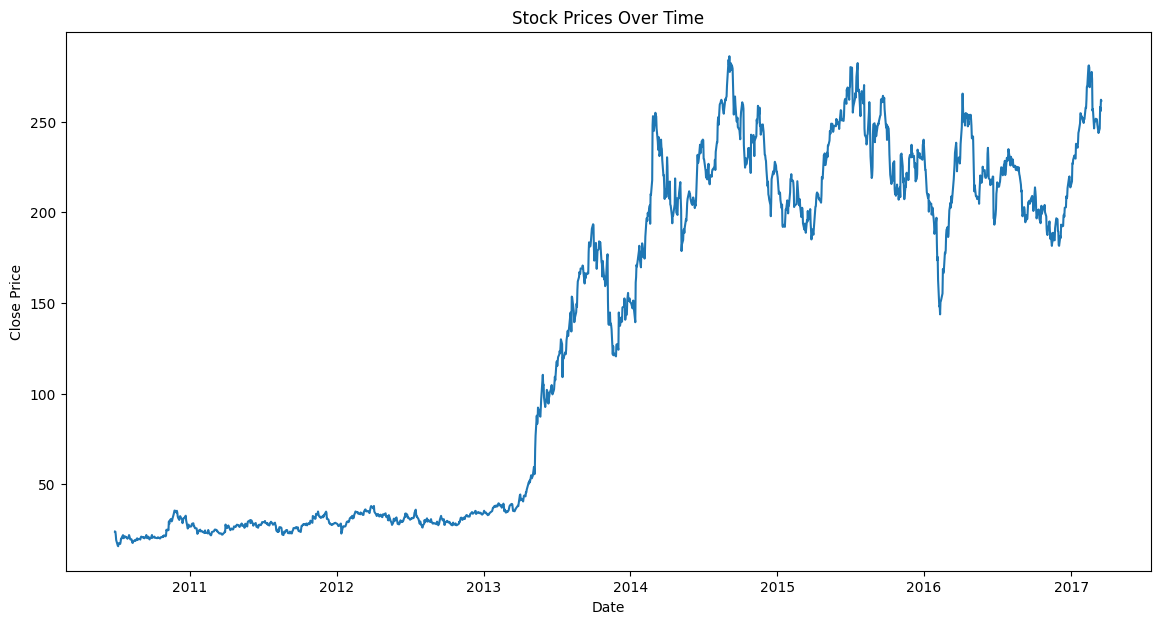

In [ ]:
# use pit to visualize stock prices over the time, so we can understand the trends
plt.figure(figsize=(14, 7))
plt.plot(df['Close'])
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

**LSTM**

In [ ]:
# we want to make convergence faster
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

**Training** **and** **Testing**

In [ ]:
# split the scaled datat into training sets, we are going to use 80 to 20%
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# we are using the inputs to predict the output based on the later days
def create_dataset(data, time_step=1):
    X = []
    y = []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshapes the input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


**Build and Train**

In [ ]:
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

**Train Model**

In [ ]:
# training the model
hist = model.fit(X_train, y_train, batch_size=32, epochs=20, verbose=2)

Epoch 1/20
41/41 - 12s - loss: 0.0247 - 12s/epoch - 282ms/step
Epoch 2/20
41/41 - 7s - loss: 0.0032 - 7s/epoch - 162ms/step
Epoch 3/20
41/41 - 5s - loss: 0.0029 - 5s/epoch - 114ms/step
Epoch 4/20
41/41 - 5s - loss: 0.0032 - 5s/epoch - 113ms/step
Epoch 5/20
41/41 - 7s - loss: 0.0028 - 7s/epoch - 165ms/step
Epoch 6/20
41/41 - 5s - loss: 0.0029 - 5s/epoch - 112ms/step
Epoch 7/20
41/41 - 5s - loss: 0.0022 - 5s/epoch - 121ms/step
Epoch 8/20
41/41 - 6s - loss: 0.0025 - 6s/epoch - 155ms/step
Epoch 9/20
41/41 - 5s - loss: 0.0024 - 5s/epoch - 113ms/step
Epoch 10/20
41/41 - 6s - loss: 0.0021 - 6s/epoch - 135ms/step
Epoch 11/20
41/41 - 6s - loss: 0.0023 - 6s/epoch - 138ms/step
Epoch 12/20
41/41 - 6s - loss: 0.0027 - 6s/epoch - 140ms/step
Epoch 13/20
41/41 - 7s - loss: 0.0019 - 7s/epoch - 162ms/step
Epoch 14/20
41/41 - 5s - loss: 0.0020 - 5s/epoch - 113ms/step
Epoch 15/20
41/41 - 5s - loss: 0.0019 - 5s/epoch - 113ms/step
Epoch 16/20
41/41 - 7s - loss: 0.0019 - 7s/epoch - 161ms/step
Epoch 17/20
41/

**Plot the Loss**

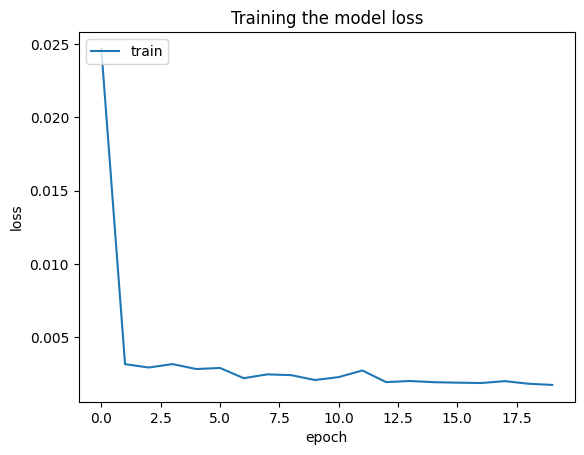

In [ ]:
plt.plot(hist.history['loss'])
plt.title('Training the model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train'], loc='upper left')
plt.show()

**Predictions**

In [ ]:
#train and test the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# since we scaled earlier we need to inverse and transform to get the actual stock prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


9/9 [==============================] - 0s 40ms/step


**Plot Predictions**

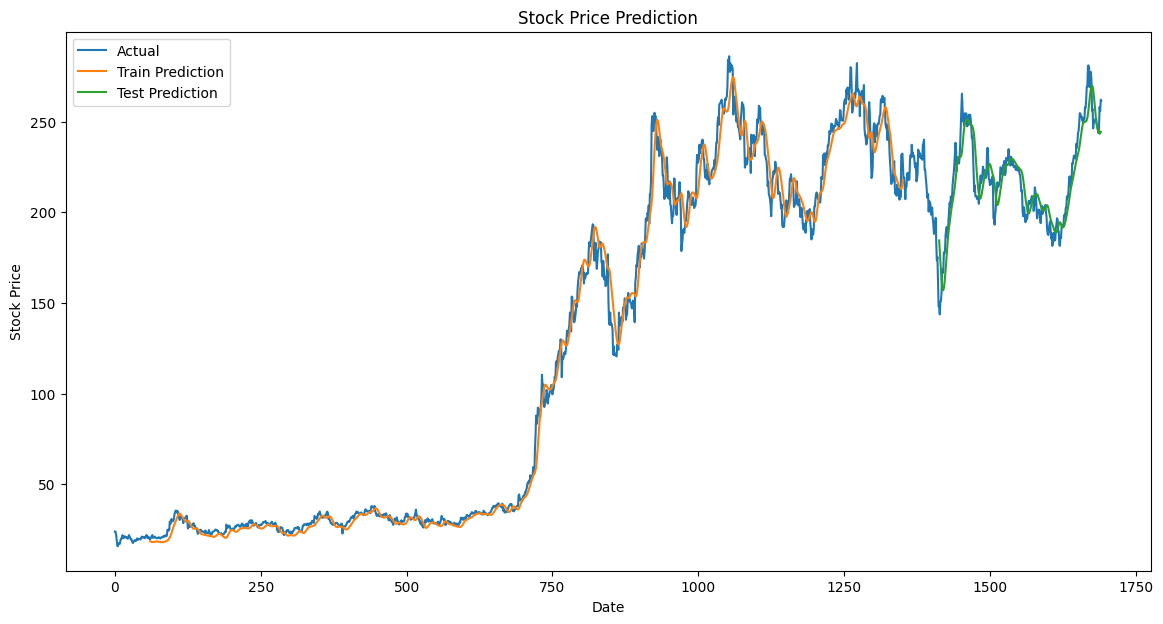

In [ ]:
# Shift train predictions for plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(['Actual', 'Train Prediction', 'Test Prediction'])
plt.show()


**Test Model With a Different Dataset**

In [ ]:
# load the data to test it
file = '/content/drive/MyDrive/apple.csv'
testData = pd.read_csv(file)

# ensuring that the Date column is parsed correctly
testData["Date"] = pd.to_datetime(testData["Date"])
testData.set_index('Date', inplace=True)

# this selects the 'Close' column and drop any None or empty values
testData = testData[['Close']].dropna()

# normalize the dataset using the same scaler we used during training
scaler = MinMaxScaler(feature_range=(0, 1))
input_closingScaled = scaler.fit_transform(testData.values)

# check the shape of the scaled data
input_closingScaled.shape

(10409, 1)

In [ ]:
# initialize variables for testing
x_test = []
time_step = 60
length = len(testData)

# create input sequences for the test model
for i in range(time_step, length):
    x_test.append(input_closingScaled[i-time_step:i, 0])

# convert to numpy array and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape


(10349, 60, 1)

In [ ]:
# makes the prediction
y_pred = model.predict(x_test)

# we inverse transform the predictions to get actual stock prices
predicted_price = scaler.inverse_transform(y_pred)


324/324 [==============================] - 15s 46ms/step


**Visualization**

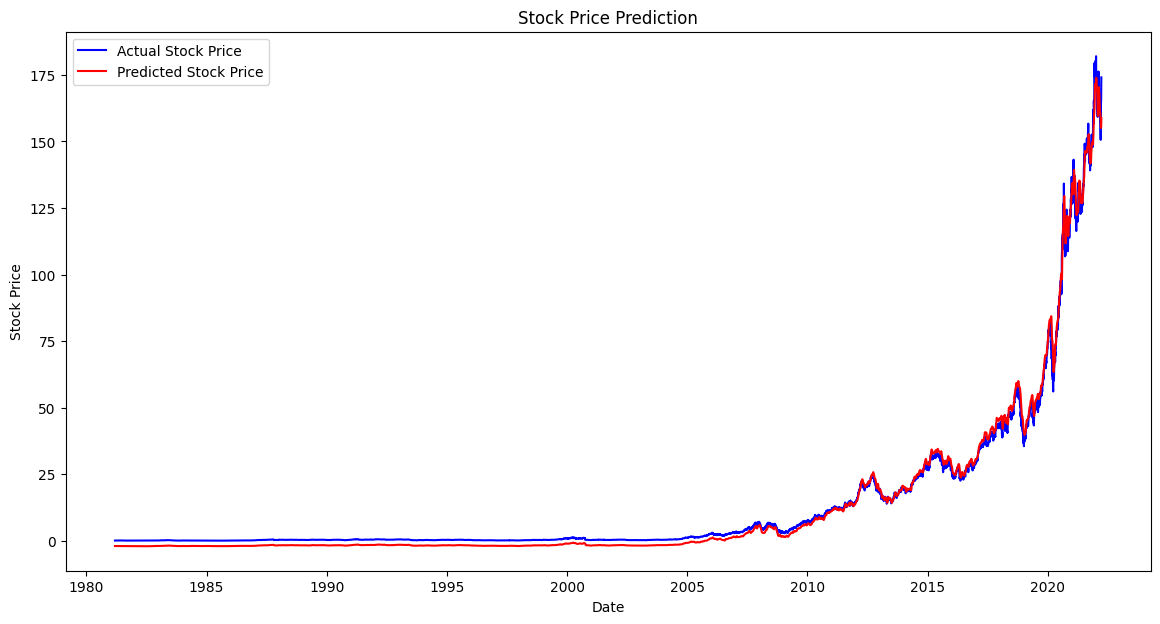

In [ ]:
# get the actual closing prices for comparison
y_test = testData.iloc[time_step:, 0].values

# plot the results
plt.figure(figsize=(14, 7))
plt.plot(testData.index[time_step:], y_test, color='blue', label='Actual Stock Price')
plt.plot(testData.index[time_step:], predicted_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


**Performance Metrics**

In [ ]:
# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test, predicted_price)
rmse = np.sqrt(mse)

# Print the performance metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 4.7516174723392695
Root Mean Squared Error (RMSE): 2.179820513789901


In [ ]:
from tensorflow.keras.models import load_model
import joblib

# Save the model
model.save('stock_prediction_model.h5')

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
